# Ice Algae timing diagnostics

Diagnostics of light and N limitation timing

Computation from daily data

Plots of single cells

## Setup

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import palettable.cmocean.sequential as cmOcSeq
import palettable.cmocean.diverging as cmOcDiv
import seaborn as sns

from datetime import datetime, timedelta

from glob import glob 

import utilsRegions as urgn
import utilsGen as utl
import mapPlots as mplt
import diagnostics as dgnst
import utlshistograms as uhist

%load_ext autoreload
%autoreload 2

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(dashboard_address=':8188',n_workers=16, threads_per_worker=1)
client = Client(cluster)

http://127.0.0.1:8188/status

In [12]:
cluster.close()
client.close()

### Load data

In [3]:
scenarios = ['historical-DFS-G510.00','RCP85-G510.14-G515.00-01']
hist,rcp85 = scenarios
periods = ['1981-2000','2023-2042','2066-2085']
past,pres,futur=periods
runs={past:hist, pres:rcp85, futur:rcp85}
timeperiod = {past: slice('1981','2000'), pres:slice('2023','2042'), futur: slice('2066','2085') }

dadic={}
datadir = '/tsanta/ahaddon/data/'
utl.loadNAAmesh(dadic)

In [11]:
for scn in scenarios:
    dadic[scn+'biolog'] = xr.open_mfdataset(datadir+scn+'/NAA_1d_*_biolog.nc', combine='by_coords', parallel=True).chunk(chunks={'time_counter':365,'x':100,'y':100})
    dadic[scn+'diad'] = xr.open_mfdataset(datadir+scn+'/NAA_730h_*_diad_T.nc', combine='by_coords', parallel=True)

In [12]:
dadic[scn+'biolog']

<xarray.Dataset>
Dimensions:            (time_counter: 25550, y: 400, x: 568, deptht: 46,
                        tbnds: 2)
Coordinates:
  * deptht             (deptht) float32 0.5487 1.973 ... 5.622e+03 5.878e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time_counter       (time_counter) object 2016-01-01 12:00:00 ... 2085-12-...
Dimensions without coordinates: y, x, tbnds
Data variables: (12/19)
    Cflx               (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    Delc               (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    Kg                 (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    SSS                (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    SST                (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    fstricgca          (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    ...                 ...
    pCO2_atm           (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    pCO2_sw            (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    sfcocedms          (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    sfcoceno3          (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    sfcocepar          (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    time_counter_bnds  (time_counter, tbnds) object dask.array<chunksize=(365, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.1
    production:   An IPSL model
    TimeStamp:    23/12/2020 00:39:33 -0500
    file_name:    NAA_1d_20160101_20161231_biolog.nc
    history:      Wed Dec 23 05:34:27 2020: ncks -4 -L 1 -O NAA_1d_20160101_2...
    NCO:          4.6.6

## Climatologies

In [ ]:
clim={}
for per in periods: 
    scn=runs[per]
    print('\n'+per)
    clim[per+'ileadfra2'] = utl.climatology(dadic, scn, 'biolog', 'ileadfra2', group='day', gca=False, fillna=0.,timeperiod=timeperiod[per])
    clim[per+'iicethic'] = utl.climatology(dadic, scn, 'biolog', 'iicethicgca', group='day', gca=True, fillna=0.,timeperiod=timeperiod[per])
    clim[per+'isnowthi'] = utl.climatology(dadic, scn, 'biolog', 'isnowthigca', group='day', gca=True, fillna=0.,timeperiod=timeperiod[per])
    clim[per+'icedia'] = utl.climatology(dadic, scn, 'biolog', 'icediagca', group='day', gca=True, unitName='mmol C m$^{-2}$', fillna=0.,timeperiod=timeperiod[per])  
    clim[per+'fstric'] = utl.climatology(dadic, scn, 'biolog', 'fstricgca', group='day', gca=True, fillna=0.,timeperiod=timeperiod[per])
    clim[per+'iceno3'] = utl.climatology(dadic, scn, 'biolog', 'iceno3gca', group='day', gca=True, fillna=0.,timeperiod=timeperiod[per])
    clim[per+'icenh4'] = utl.climatology(dadic, scn, 'diad', 'icenh4', group='time_counter.month', convFac=0.03 , fillna=0.,timeperiod=timeperiod[per]) #convert to mmol m^-2
    clim[per+'icenh4']= utl.resampleClimDaily(clim[per+'icenh4'])

In [5]:
clim={}
for per in periods: 
    scn=runs[per]
    print('\n'+per)
    clim[per+'iceNPPgca'] = utl.climatology(dadic, scn, 'biolog', 'icenppgca', group='day', unitName='mmol C m$^{-2}$', fillna=0.,timeperiod=timeperiod[per])   
    clim[per+'iceNPPyrly'] =clim[per+'iceNPPgca'].sum(dim='dayofyear')


1981-2000
icenppgca 
2023-2042
icenppgca 
2066-2085
icenppgca 

In [6]:
clim={}
for per in periods: 
    scn=runs[per]
    print('\n'+per)
    clim[per+'iceGPPgca'] = utl.climatology(dadic, scn, 'biolog', 'icegppgca', group='day', unitName='mmol C m$^{-2}$', fillna=0.,timeperiod=timeperiod[per])   
    clim[per+'iceGPPfall'] =clim[per+'iceGPPgca'].isel(dayofyear=slice(244,-1)).sum(dim='dayofyear')


1981-2000
icegppgca 
2023-2042
icegppgca 
2066-2085
icegppgca 

#### Save

In [8]:
# varsave = ['ileadfra2','icedia','fstric','iceno3','icenh4','iicethic','isnowthi']
varsave = ['iceGPPgca','iceGPPfall']
for per in periods: 
    scn=runs[per]
    for var in varsave:
        clim[per+var].where(dadic['landMask']).to_netcdf(f'/tsanta/ahaddon/NAA/processedData/{scn}/panArctic/{var}_20yclim{per}_1d.nc')

## Diagnostics

from model output directly

### single year check

In [ ]:
scn=scenarios[1]

# xi,yi =[limpar.max(dim=['time_counter']).argmax(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]
# xi,yi =[doyNlim.argmax(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]
# xi,yi=259, 119 ##CAA nemesis
# xi,yi=379, 2 ## low lat N snd spike
# xi,yi= 150,150 # beafirt low
# xi,yi=158, 92 ## amundsen gulf 2nd N max
xi,yi=310, 100 ## baffin 2nd N

# xi,yi =[clim[scn+'icedia'].sel(dayofyear=slice(250,365)).max(dim=['dayofyear']).argmax(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]

# xi,yi = [doySIbu.where(doySIbu>50).argmin(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]
xi,yi=412, 194 # greenland crazy ice
# xi,yi=128, 110 ## near amdmusen
xi,yi=180,345 #siberia
print(xi,yi)


pc,nc,ic='tab:orange','tab:blue','r'
fig,ax=plt.subplots(1,2,figsize=(16,5))
days=range(1,366)
    
ax[0].plot(days,limpar.isel(x=xi,y=yi),'.',c=pc,ms=2)
smLpar = limpar.isel(x=xi,y=yi).rolling(time_counter=5,min_periods=1,center=True).mean()
ax[0].plot(days,smLpar,c=pc,label='PAR lim')
dlimP = doyPARlim.isel(x=xi,y=yi)
ax[0].plot([dlimP,dlimP],[0,0.5],'--',c=pc)
# dlimP = dgnst.doyPARlim(clim[scn+'limpar'].isel(x=xi,y=yi),0.5)
# ax[0].plot([dlimP,dlimP],[0,0.5],'--',c=pc)

ax[0].plot(days,limN.isel(x=xi,y=yi),'.',c=nc,ms=0.5)
smLn = limN.isel(x=xi,y=yi).rolling(time_counter=5,min_periods=1,center=True).mean()
ax[0].plot(days,smLn,c=nc,label='N lim')
dlimN = doyNlim.isel(x=xi,y=yi)
ax[0].plot([dlimN,dlimN],[0,0.5],'--',c=nc)
# dlimN2= dgnst.doyNlim(clim[scn+'limN'].isel(x=xi,y=yi),0.5)
# ax[0].plot([dlimN2,dlimN2],[0,0.5],'--',c=nc)

sicy=sic.sel(time_counter=year)
ax[0].plot(days,sicy.isel(x=xi,y=yi),'.',c=ic,ms=2)
smSic = sicy.isel(x=xi,y=yi).rolling(time_counter=5,min_periods=1,center=True).mean()
ax[0].plot(days,smSic,c=ic,label='SI conc')
dlimSIb = doySIbu.isel(x=xi,y=yi)
# dlimSIb = dgnst.doySIbreak(clim[scn+'ileadfra2'].isel(x=xi,y=yi),0.5)
ax[0].plot([dlimSIb,dlimSIb],[0,0.5],'--',c=ic)

ax[0].legend(loc='center right')
ax[0].plot([1,365],[0.5,0.5],'k')

dlim = doySwitch.isel(x=xi,y=yi)
# ax[0].plot([dlim,dlim],[0,limpar.isel(x=xi,y=yi).sel(time_counter=limpar.time_counter.dt.dayofyear.isin([dlim]))[0]],'k--')
ax[0].plot([dlim,dlim],[0,limswitch.isel(x=xi,y=yi)],'k--')

least_lim = leastlim.isel(x=xi,y=yi)
ax[0].plot([1,365],[least_lim]*2,'-.')


# dSIfu = dgnst.doySIfreezeUp(clim[scn+'ileadfra2'].isel(x=xi,y=yi),0.5)
# print(dSIfu)
# ax[0].plot([dSIfu,dSIfu],[0,0.5],'-.',c=ic)


IA=ia.isel(x=xi,y=yi)
ax[1].plot(days,IA,'g',label='IA')
# ax[1].plot([0,365],[IA.mean()]*2,'g--',label='mean')
# ax[1].plot([60,180],[IA.sel(dayofyear=slice(60,180)).mean()]*2,'g-.',label='mean MAMJ')
# ax[1].plot([0,365],[IA.std()]*2,'g:',label='std')
ax[1].legend()
    
iamax=IA.max()
ax[1].plot([dlimP,dlimP],[0,iamax],'--',c=pc)
ax[1].plot([dlimN,dlimN],[0,iamax],'--',c=nc)
ax[1].plot([dlim,dlim],[0,iamax],'k--')
ax[1].plot([dlimSIb,dlimSIb],[0,iamax],'--',c=ic)
# ax[1].plot([dSIfu,dSIfu],[0,iamax],'-.',c=ic)

fig,ax = mplt.initmaps()
ax.plot(dadic['mesh'].nav_lon.isel(x=xi,y=yi), dadic['mesh'].nav_lat.isel(x=xi,y=yi), 'o', ms=5,
        transform=ccrs.PlateCarree())


### Compute and save

#### Growth limitations 

In [ ]:
for per in periods[:1]: 
    print(per)
    scn=runs[per]
    dly=dadic[scn+'biolog'].sel(time_counter=timeperiod[per]).where(dadic['mesh'].nav_lat>60).chunk({'x':100,'y':100})

    par_insitu = dly.fstricgca/dly.ileadfra2.where(dly.ileadfra2>0)
    limpar = dgnst.limPAR(par_insitu)
    limpar.name ='limpar'
    limpar.to_netcdf(f'/tsanta/ahaddon/NAA/processedData/{scn}/panArctic/limpar_{per}_1d.nc')
    del par_insitu, limpar
    
    nh4_m = dadic[scn+'diad'].icenh4.sel(time_counter=timeperiod[per]).where(dadic['mesh'].nav_lat>60).chunk({'x':100,'y':100})
    # # interp on the entire 30 years will output a single chunk, cause lot of data loaded in ram
    # # group by year to do 1 year at a time and end up with 1 chunk/year
    nh4_dly= nh4_m.groupby('time_counter.year').map(lambda dn : 0.03*dn.interp(
                    time_counter=dly.iceno3gca.time_counter.sel(time_counter=str(dn.time_counter.dt.year.values[0])), kwargs={"fill_value": "extrapolate"} ))
    no3_insitu = dly.iceno3gca/dly.ileadfra2.where(dly.ileadfra2>0)
    limN = dgnst.limN(nh4_dly + no3_insitu)
    limN.name='limN'
    limN.to_netcdf(f'/tsanta/ahaddon/NAA/processedData/{scn}/panArctic/limN_{per}_1d.nc')
    del limN, nh4_m, no3_insitu

Load growth lim (not averaged)

In [6]:
lim={}
for per in periods: 
    scn=runs[per]
    lim[per+'limpar'] = xr.open_mfdataset(f'/tsanta/ahaddon/NAA/processedData/{scn}/panArctic/limpar_{per}_1d.nc', 
                                          chunks={'time_counter':365,'x':100,'y':100})
    lim[per+'limN'] = xr.open_mfdataset(f'/tsanta/ahaddon/NAA/processedData/{scn}/panArctic/limN_{per}_1d.nc', 
                                        chunks={'time_counter':365,'x':100,'y':100})

In [7]:
lim[past+'limN']

<xarray.Dataset>
Dimensions:       (y: 400, x: 568, time_counter: 7300)
Coordinates:
    nav_lat       (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time_counter  (time_counter) object 1981-01-01 12:00:00 ... 2000-12-31 12...
Dimensions without coordinates: y, x
Data variables:
    limN          (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>

#### Key dates

In [ ]:
for per in periods[2:]: 
    print(per)
    scn=runs[per]
    savedir = f'/tsanta/ahaddon/NAA/processedData/{scn}/panArctic/'
    
    lim[per+'limpar'].groupby('time_counter.year').map(dgnst.doyPARlim, timedim='time_counter', threshold=0.155 ).rename({'limpar':'doyPARlim15'}).to_netcdf(f'{savedir}doyPARlim15_{per}.nc')
    
    lim[per+'limpar'].groupby('time_counter.year').map(dgnst.doyPARlim, timedim='time_counter' ).rename({'limpar':'doyPARlim5'}).to_netcdf(f'{savedir}doyPARlim5_{per}.nc')
    
    lim[per+'limN'].groupby('time_counter.year').map(dgnst.doyNlim, timedim='time_counter' ).rename({'limN':'doyNlim5'}).to_netcdf(f'{savedir}doyNlim5_{per}.nc')
    
    dly=dadic[scn+'biolog'].sel(time_counter=timeperiod[per]).where(dadic['mesh'].nav_lat>60)
    dly.ileadfra2.groupby('time_counter.year').map(dgnst.doySIbreak,timedim='time_counter' ).rename('doySIbreak').to_netcdf(f'{savedir}doySIbreak_{per}.nc')

 Other dates and diagnostics

In [ ]:
for per in periods[2:]: 
    print(per)
    scn=runs[per]
    savedir = f'/tsanta/ahaddon/NAA/processedData/{scn}/panArctic/'
    
    # Intermediate load to compute other dates
    diagn = xr.open_mfdataset(f'{savedir}doy*_{per}.nc')
    
    diagn['doyPARlimGTnlim'] = xr.merge([lim[per+'limpar'], lim[per+'limN']]).groupby('time_counter.year').map(lambda ds:
                                          dgnst.doyPARlimGTnlim(ds.limpar, ds.limN, timedim='time_counter') )
    
    diagn['least_lim'] = xr.merge([lim[per+'limpar'], lim[per+'limN']]).groupby('time_counter.year').map(lambda ds:
                                          dgnst.least_lim(ds.limpar, ds.limN, timedim='time_counter') )
    
    diagn['nonLimGwth'] = diagn.groupby('year').map(lambda ds:
                                          dgnst.lenghtNonLimGrwth(ds.doyPARlim5, ds.doyNlim5, ds.doySIbreak) )
    
    sic = dadic[scn+'biolog'].sel(time_counter=timeperiod[per]).where(dadic['mesh'].nav_lat>60).ileadfra2
    diagn['lengthPAR'] = dgnst.lengthPAR(sic, diagn.doySIbreak, diagn.doyPARlim15)
    
    # save
    diagn.to_netcdf(f'{savedir}IAdiagnostics_{per}_1y.nc')
    del diagn

day of max IA and freeze up

In [ ]:
for per in periods[2:]: 
    print(per)
    scn=runs[per]
    savedir = f'/tsanta/ahaddon/NAA/processedData/{scn}/panArctic/'
    
    #load other diagnostics
    diagn= xr.open_mfdataset(f'{savedir}IAdiagnostics_{per}_1y.nc')

    dly=dadic[scn+'biolog'].sel(time_counter=timeperiod[per]).where(dadic['mesh'].nav_lat>60)

    # max IA
    ia = dly.icediagca /dly.ileadfra2.where(dly.ileadfra2)
    diagn['doyIApeak'] = ia.groupby('time_counter.year').map(dgnst.doyIApeak,timedim='time_counter')

    # freeze up
    diagn['doySIfreezeUp'] = dly.ileadfra2.groupby('time_counter.year').map(dgnst.doySIfreezeUp,timedim='time_counter')
    
    # save
    diagn.to_netcdf(f'{savedir}IAdiagnostics+max_{per}_1y.nc')
    del diagn

day of IA = 1 std

In [5]:
for per in periods: 
    print(per)
    scn=runs[per]
    savedir = f'/tsanta/ahaddon/NAA/processedData/{scn}/panArctic/'
    
    #load other diagnostics
    diagn= xr.open_mfdataset(f'{savedir}IAdiagnostics+max_{per}_1y.nc')

    dly=dadic[scn+'biolog'].sel(time_counter=timeperiod[per]).where(dadic['mesh'].nav_lat>60)

    #  IA = std
    ia = dly.icediagca /dly.ileadfra2.where(dly.ileadfra2)
    diagn['doyIAstd'] = ia.groupby('time_counter.year').map(dgnst.doyIAstd,timedim='time_counter')
    
    # save
    diagn.to_netcdf(f'{savedir}IAdiagnostics+max+std_{per}_1y.nc')
    del diagn

1981-2000
2023-2042
2066-2085


#### Load diagnostics (not averged)

In [8]:
diagn={}
for per in periods: 
    scn=runs[per] 
    savedir = f'/tsanta/ahaddon/NAA/processedData/{scn}/panArctic/'
    diagn[per]= xr.open_dataset(f'{savedir}IAdiagnostics+max+std_{per}_1y.nc')

In [9]:
diagn[futur]

<xarray.Dataset>
Dimensions:          (year: 20, y: 400, x: 568)
Coordinates:
    nav_lat          (y, x) float32 ...
    nav_lon          (y, x) float32 ...
  * year             (year) int64 2066 2067 2068 2069 ... 2082 2083 2084 2085
Dimensions without coordinates: y, x
Data variables:
    doyNlim5         (year, y, x) float64 ...
    doyPARlim15      (year, y, x) float64 ...
    doyPARlim5       (year, y, x) float64 ...
    doySIbreak       (year, y, x) float64 ...
    doyPARlimGTnlim  (year, y, x) float64 ...
    least_lim        (year, y, x) float32 ...
    nonLimGwth       (year, y, x) float64 ...
    lengthPAR        (year, y, x) float64 ...
    doyIApeak        (year, y, x) float64 ...
    doySIfreezeUp    (year, y, x) float64 ...
    doyIAstd         (year, y, x) float64 ...

#### checks

200 150


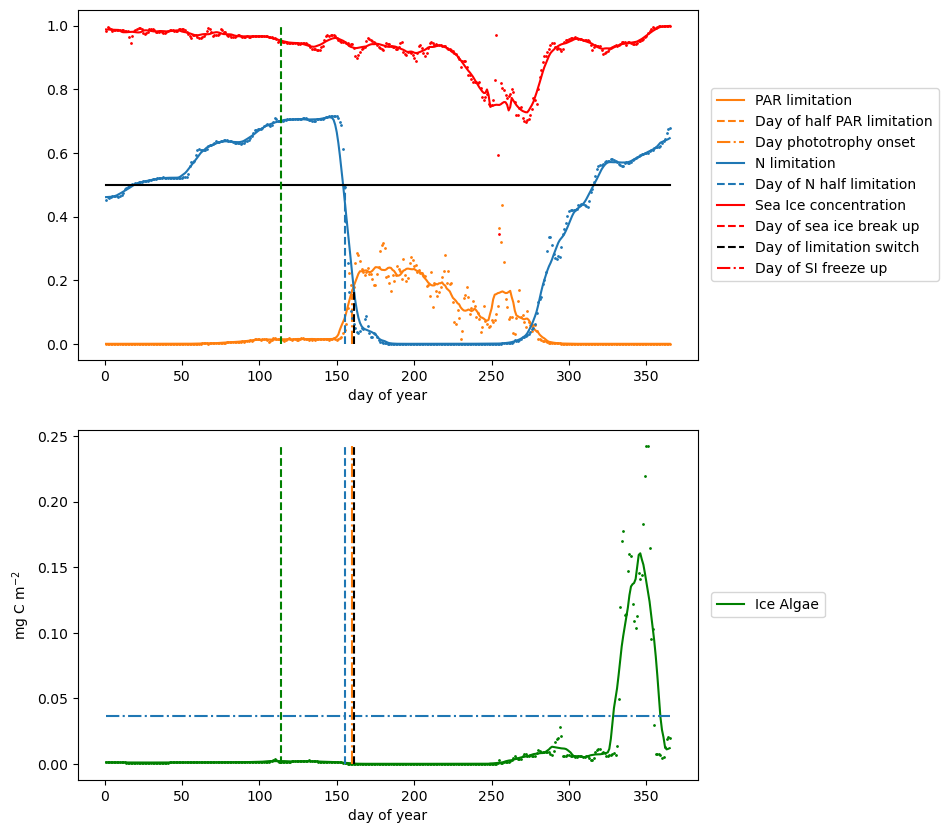

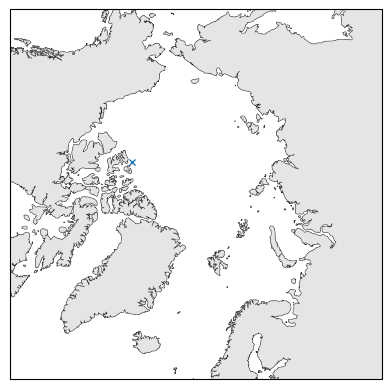

In [16]:
per=past
year=1998

limpar=lim[per+'limpar'].sel(time_counter=str(year)).limpar
limN=lim[per+'limN'].sel(time_counter=str(year)).limN
doyPARlim = diagn[per].doyPARlim5.sel(year=year)
doyPARlim15 = diagn[per].doyPARlim15.sel(year=year)
doyNlim = diagn[per].doyNlim5.sel(year=year)
sicy=dadic[runs[per]+'biolog'].ileadfra2.sel(time_counter=str(year))
doySIbu=diagn[per].doySIbreak.sel(year=year)
doySwitch=diagn[per].doyPARlimGTnlim.sel(year=year)
doyIApeak=diagn[per].doyIApeak.sel(year=year)
doyIAstd=diagn[per].doyIAstd.sel(year=year)
doySIfreezeUp=diagn[per].doySIfreezeUp.sel(year=year)
leastlim=diagn[per].least_lim.sel(year=year)
ia=dadic[runs[per]+'biolog'].icediagca.sel(time_counter=str(year))


# xi,yi =[limpar.max(dim=['time_counter']).argmax(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]
# xi,yi =[doyNlim.argmax(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]
# xi,yi=259, 119 ##CAA nemesis
# xi,yi=379, 2 ## low lat N snd spike
# xi,yi= 150,150 # beafirt low
xi,yi= 200,150 # LIA
# xi,yi=158, 92 ## amundsen gulf 2nd N max
# xi,yi=310, 100 ## baffin 2nd N

# xi,yi =[clim[per+'icedia'].sel(dayofyear=slice(250,365)).max(dim=['dayofyear']).argmax(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]

# xi,yi = [doySIbu.where(doySIbu>50).argmin(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]
# xi,yi=412, 194 # greenland crazy ice
# xi,yi=128, 110 ## near amdmusen
# xi,yi=180,345 #siberia
# xi,yi=85,288 #siberia

# xi,yi= 235, 46  #CAA
# xi,yi= 180, 52  #CAA
# xi,yi=148, 87#CAA
# xi,yi=180, 55 ## in paper

print(xi,yi)


pc,nc,ic,iac='tab:orange','tab:blue','r','g'
fig,ax=plt.subplots(2,1,figsize=(8,10))
days=range(1,366)
    
ax[0].plot(days,limpar.isel(x=xi,y=yi),'.',c=pc,ms=2)
smLpar = limpar.isel(x=xi,y=yi).rolling(time_counter=14,min_periods=1,center=True).mean()
ax[0].plot(days,smLpar,c=pc,label='PAR limitation')
dlimP = doyPARlim.isel(x=xi,y=yi)
ax[0].plot([dlimP,dlimP],[0,0.5],'--',c=pc, label='Day of half PAR limitation')
dlimP15 = doyPARlim15.isel(x=xi,y=yi)
ax[0].plot([dlimP15,dlimP15],[0,0.155],'-.',c=pc, label='Day phototrophy onset')
# dlimP = dgnst.doyPARlim(clim[per+'limpar'].isel(x=xi,y=yi),0.5)
# ax[0].plot([dlimP,dlimP],[0,0.5],'--',c=pc)

ax[0].plot(days,limN.isel(x=xi,y=yi),'.',c=nc,ms=2)
smLn = limN.isel(x=xi,y=yi).rolling(time_counter=14,min_periods=1,center=True).mean()
ax[0].plot(days,smLn,c=nc,label='N limitation')
dlimN = doyNlim.isel(x=xi,y=yi)
ax[0].plot([dlimN,dlimN],[0,0.5],'--',c=nc, label='Day of N half limitation')
# dlimN2= dgnst.doyNlim(clim[per+'limN'].isel(x=xi,y=yi),0.5)
# ax[0].plot([dlimN2,dlimN2],[0,0.5],'--',c=nc)

ax[0].plot(days,sicy.isel(x=xi,y=yi),'.',c=ic,ms=2)
smSic = sicy.isel(x=xi,y=yi).rolling(time_counter=14,min_periods=1,center=True).mean()
ax[0].plot(days,smSic,c=ic,label='Sea Ice concentration')
dlimSIb = doySIbu.isel(x=xi,y=yi)
# dlimSIb = dgnst.doySIbreak(clim[per+'ileadfra2'].isel(x=xi,y=yi),0.5)
ax[0].plot([dlimSIb,dlimSIb],[0,0.5],'--',c=ic, label='Day of sea ice break up')

ax[0].legend(loc='center right')
ax[0].plot([1,365],[0.5,0.5],'k')

dlim = doySwitch.isel(x=xi,y=yi)
ax[0].plot([dlim,dlim],[0,smLn.isel(time_counter=int(dlim)-1)],'k--', label='Day of limitation switch')
# ax[0].plot([dlim,dlim],[0,limswitch.isel(x=xi,y=yi)],'k--')

# least_lim = leastlim.isel(x=xi,y=yi)
# ax[0].plot([1,365],[least_lim]*2,'g-.', label='Least limitation')


# dSIfu = dgnst.doySIfreezeUp(sicy.isel(x=xi,y=yi),threshold=0.5,timedim='time_counter')
dSIfu = doySIfreezeUp.isel(x=xi,y=yi)
ax[0].plot([dSIfu,dSIfu],[0,0.5],'-.',c=ic, label='Day of SI freeze up')





ax[0].legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1)   
ax[0].set_xlabel('day of year')





IA=ia.isel(x=xi,y=yi)/sicy.isel(x=xi,y=yi).where(sicy.isel(x=xi,y=yi)) *12
ax[1].plot(days,IA.rolling(time_counter=14,min_periods=1,center=True).mean(),'g',label='Ice Algae')
ax[1].plot(days,IA,'g.',ms=2)
ax[1].legend()

# dmxIA = dgnst.doyIApeak(IA,timedim='time_counter')
dmxIA = doyIApeak.isel(x=xi,y=yi)
ax[0].plot([dmxIA,dmxIA],[0,1],'--',c=iac, label='Day of IA peak')

# dstdIA=dgnst.doyIAstd(IA,timedim=timedim)
dstdIA=doyIAstd.isel(x=xi,y=yi)
ax[0].plot([dstdIA,dstdIA],[0,1],'-.',c=iac, label='Day of IA =std')
ax[1].plot([1,365],[IA.fillna(0).std()]*2,'-.')
    
iamax=IA.max()
ax[1].plot([dmxIA,dmxIA],[0,iamax],'--',c=iac)
ax[1].plot([dstdIA,dstdIA],[0,iamax],'-.',c=iac)
ax[1].plot([dlimP15,dlimP15],[0,iamax],'-.',c=pc)
ax[1].plot([dlimP,dlimP],[0,iamax],'--',c=pc)
ax[1].plot([dlimN,dlimN],[0,iamax],'--',c=nc)
ax[1].plot([dlim,dlim],[0,iamax],'k--')
ax[1].plot([dlimSIb,dlimSIb],[0,iamax],'--',c=ic)
ax[1].plot([dSIfu,dSIfu],[0,iamax],'-.',c=ic)

ax[1].legend(loc='center left', bbox_to_anchor=(1.01, 0.5))   
ax[1].set_xlabel('day of year')
ax[1].set_ylabel('mg C m$^{-2}$')


fig,ax = mplt.initmaps()
ax.plot(dadic['mesh'].nav_lon.isel(x=xi,y=yi), dadic['mesh'].nav_lat.isel(x=xi,y=yi), 'x', ms=5,
        transform=ccrs.PlateCarree())


### Climatological averages of diagnostics

- \+ numbers of years a diagnostic is defined

In [16]:
for per in periods: 
    scn=runs[per] 
    savedir = f'/tsanta/ahaddon/NAA/processedData/{scn}/panArctic/'
    print(per)
    # averags of diagnostics
    lim[per+'limpar'].limpar.groupby('time_counter.dayofyear').mean().to_netcdf(f'{savedir}limpar_20yclim{per}_1d.nc')
    lim[per+'limN'].limN.groupby('time_counter.dayofyear').mean().to_netcdf(f'{savedir}limN_20yclim{per}_1d.nc')

1981-2000
2023-2042
2066-2085


In [14]:
climdiag={}
for per in periods: 
    scn=runs[per] 
    savedir = f'/tsanta/ahaddon/NAA/processedData/{scn}/panArctic/'
    print(per)
    # averags of diagnostics
    climdiag[per]=diagn[per].mean('year')
    # number of years a diagnostic is defined
    for varn in diagn[per].data_vars:
        climdiag[per][varn+'_nyears'] = xr.where(diagn[per][varn].isnull(),0,1).sum('year')
    # number of years sea ice concentration >= 50%
    # sigt50=(dadic[scn+'biolog']['ileadfra2'].sel(time_counter=timeperiod[per]).groupby('time_counter.year').max(dim='time_counter') >= 0.5)
    # climdiag[per]['SIgt50_nyears'] = sigt50.sum('year')
    # save
    climdiag[per].to_netcdf(f'{savedir}IAdiagnostics_20yclim{per}.nc')

1981-2000
2023-2042
2066-2085


## Load

In [6]:
processDataDir = '/tsanta/ahaddon/NAA/processedData/'
# processDataDir = '/home/ahaddon/Work/NAA/processedData/'
# varsave = ['icedia','ileadfra2','fstric','iceno3','icenh4','icedia','limN','limpar']#,'iicethic','isnowthi'
varsave = ['icedia','iceGPPfall']#,'iicethic','isnowthi'
clim={}
for per in periods: 
    scn=runs[per] 
    for var in varsave:
        clim[per+var] = xr.open_dataarray(f'{processDataDir}{scn}/panArctic/{var}_20yclim{per}_1d.nc')

In [7]:
for per in periods: 
    clim[per+'meanIA'] = clim[per+'icedia'].sel(dayofyear=slice(60,181)).mean(dim='dayofyear').compute()
    clim[per+'peakIAfall'] = clim[per+'icedia'].sel(dayofyear=slice(250,365)).max(dim='dayofyear').compute()
    clim[per+'peakIA'] = clim[per+'icedia'].sel(dayofyear=slice(1,250)).max(dim='dayofyear').compute()
diffIAmean=clim[futur+'meanIA'] - clim[past+'meanIA'].compute()
diffIApeak=clim[futur+'peakIA'] - clim[past+'peakIA'].compute()

In [8]:
climdiag={}
for per in periods:
    scn=runs[per] 
    climdiag[per] = xr.open_dataset(f'{processDataDir}{scn}/panArctic/IAdiagnostics_20yclim{per}.nc').compute()
climdiag[periods[0]]

<xarray.Dataset>
Dimensions:                 (y: 400, x: 568)
Coordinates:
    nav_lat                 (y, x) float32 53.41 53.48 53.56 ... 44.23 44.11
    nav_lon                 (y, x) float32 -132.6 -132.5 -132.4 ... 15.75 15.66
Dimensions without coordinates: y, x
Data variables: (12/22)
    doyNlim5                (y, x) float64 nan nan nan nan ... nan nan nan nan
    doyPARlim15             (y, x) float64 nan nan nan nan ... nan nan nan nan
    doyPARlim5              (y, x) float64 nan nan nan nan ... nan nan nan nan
    doySIbreak              (y, x) float64 nan nan nan nan ... nan nan nan nan
    doyPARlimGTnlim         (y, x) float64 nan nan nan nan ... nan nan nan nan
    least_lim               (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                      ...
    least_lim_nyears        (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    nonLimGwth_nyears       (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    lengthPAR_nyears        (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    doyIApeak_nyears        (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    doySIfreezeUp_nyears    (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    doyIAstd_nyears         (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

## Single cell plots

#### with IA

128 110


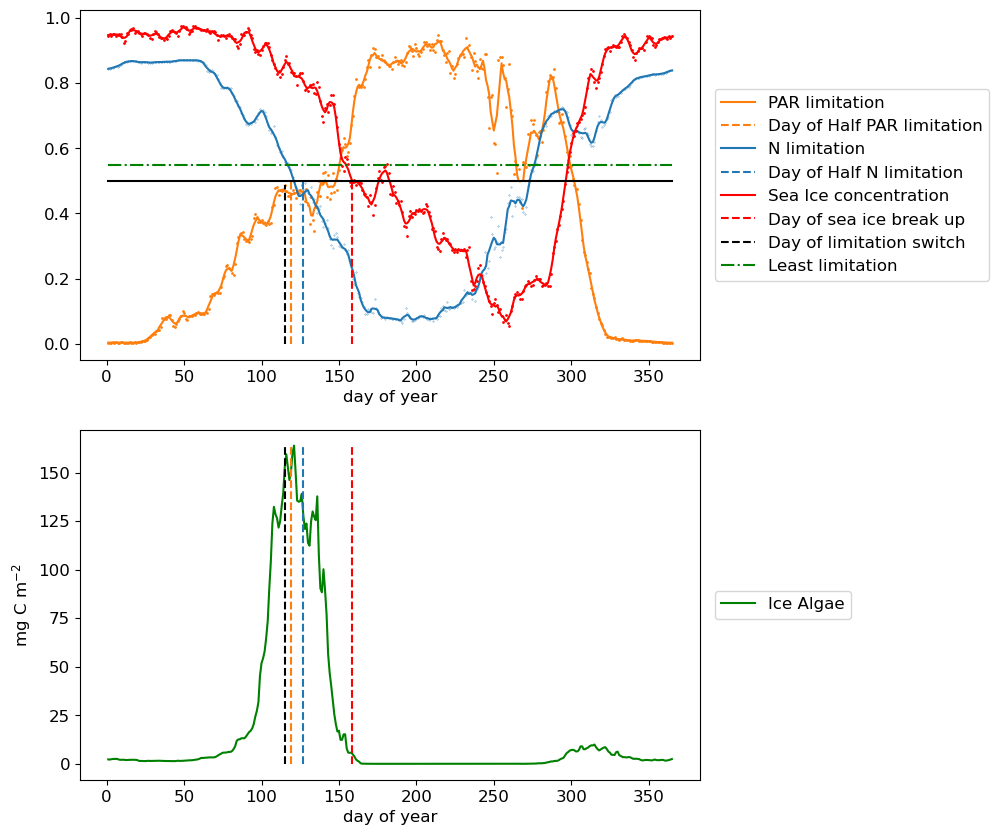

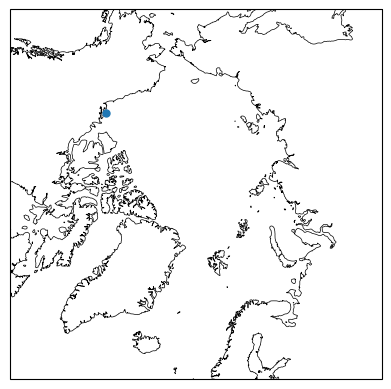

In [27]:
per=past

limpar=clim[per+'limpar']
limN=clim[per+'limN']
doyPARlim = climdiag[per].doyPARlim5
doyNlim = climdiag[per].doyNlim5
doySIbu=climdiag[per].doySIbreak
doySwitch=climdiag[per].doyPARlimGTnlim
leastlim=climdiag[per].least_lim
ia=clim[per+'icedia']
sicy=clim[per+'ileadfra2']


# xi,yi =[limpar.max(dim=['time_counter']).argmax(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]
# xi,yi =[doyNlim.argmax(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]
# xi,yi=259, 119 ##CAA nemesis
# xi,yi=379, 2 ## low lat N snd spike
# xi,yi= 150,150 # beafirt low
# xi,yi=158, 92 ## amundsen gulf 2nd N max
# xi,yi=310, 100 ## baffin 2nd N

# xi,yi =[clim[per+'icedia'].sel(dayofyear=slice(250,365)).max(dim=['dayofyear']).argmax(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]

# xi,yi = [doySIbu.where(doySIbu>50).argmin(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]
# xi,yi=412, 194 # greenland crazy ice
xi,yi=128, 110 ## near amdmusen
# xi,yi=180,345 #siberia
# xi,yi=85,288 #siberia
# xi,yi= 235, 46  #CAA
# xi,yi=148, 87#CAA
# xi,yi,=160,90

print(xi,yi)


pc,nc,ic='tab:orange','tab:blue','r'
days=range(1,366)

fig,ax=plt.subplots(2,1,figsize=(8,10))


ax[0].plot(days,limpar.isel(x=xi,y=yi),'.',c=pc,ms=2)
smLpar = limpar.isel(x=xi,y=yi).rolling(dayofyear=5,min_periods=1,center=True).mean()
ax[0].plot(days,smLpar,c=pc,label='PAR limitation')
# lparSTD = climdiagstd[per+'limpar'].isel(x=xi,y=yi)
# ax[0].fill_between(days,smLpar-lparSTD, smLpar+lparSTD, color=pc, alpha=0.2)

dlimP = doyPARlim.isel(x=xi,y=yi)
ax[0].plot([dlimP,dlimP],[0,0.5],'--', c=pc, label='Day of Half PAR limitation')
# dlimPSTD = climdiagstd[per].doyPARlim5.isel(x=xi,y=yi)
# ax[0].fill_betweenx([0,0.5],[dlimP-dlimPSTD]*2, [dlimP+dlimPSTD]*2, color=pc, alpha=0.2,)

# dlimP = dgnst.doyPARlim(clim[per+'limpar'].isel(x=xi,y=yi),0.5)
# ax[0].plot([dlimP,dlimP],[0,0.5],'--',c=pc)


ax[0].plot(days,limN.isel(x=xi,y=yi),'.',c=nc,ms=0.5)
smLn = limN.isel(x=xi,y=yi).rolling(dayofyear=5,min_periods=1,center=True).mean()
ax[0].plot(days,smLn,c=nc,label='N limitation')
# lnSTD = climdiagstd[per+'limN'].isel(x=xi,y=yi)
# ax[0].fill_between(days,smLn-lnSTD, smLn+lnSTD, color=nc, alpha=0.2)

dlimN = doyNlim.isel(x=xi,y=yi)
ax[0].plot([dlimN,dlimN],[0,0.5],'--',c=nc,  label='Day of Half N limitation')
# dlimNSTD = climdiagstd[per].doyNlim5.isel(x=xi,y=yi)
# ax[0].fill_betweenx([0,0.5],[dlimN-dlimNSTD]*2, [dlimN+dlimNSTD]*2, color=nc, alpha=0.2)

# dlimN2= dgnst.doyNlim(clim[per+'limN'].isel(x=xi,y=yi),0.5)
# ax[0].plot([dlimN2,dlimN2],[0,0.5],'--',c=nc)


ax[0].plot(days,sicy.isel(x=xi,y=yi),'.',c=ic,ms=2)
smSic = sicy.isel(x=xi,y=yi).rolling(dayofyear=5,min_periods=1,center=True).mean()
ax[0].plot(days,smSic,c=ic,label='Sea Ice concentration')
dlimSIb = doySIbu.isel(x=xi,y=yi)
# dlimSIb = dgnst.doySIbreak(clim[per+'ileadfra2'].isel(x=xi,y=yi),0.5)
ax[0].plot([dlimSIb,dlimSIb],[0,0.5],'--',c=ic, label = 'Day of sea ice break up')

ax[0].plot([1,365],[0.5,0.5],'k')

dlim = doySwitch.isel(x=xi,y=yi)
ax[0].plot([dlim,dlim],[0,limpar.isel(x=xi,y=yi).sel(dayofyear=int(dlim))],'k--', label='Day of limitation switch')
# ax[0].plot([dlim,dlim],[0,limswitch.isel(x=xi,y=yi)],'k--')

least_lim = leastlim.isel(x=xi,y=yi)
ax[0].plot([1,365],[least_lim]*2,'g-.', label='Least limitation')


# dSIfu = dgnst.doySIfreezeUp(clim[per+'ileadfra2'].isel(x=xi,y=yi),0.5)
# print(dSIfu)
# ax[0].plot([dSIfu,dSIfu],[0,0.5],'-.',c=ic)




### first calulation of lim : from mean N and PAR

# limpar=clim[per+'limpar'] 
# limN= clim[per+'limN'] 

    
# # ax[0].plot(days,limpar.isel(x=xi,y=yi),'.',c=pc,ms=2)
# smLpar = limpar.isel(x=xi,y=yi).rolling(dayofyear=5,min_periods=1,center=True).mean()
# ax[0].plot(days,smLpar,c=pc,ls=':',label='PAR lim from averaged PAR')

# # ax[0].plot(days,limN.isel(x=xi,y=yi),'.',c=nc,ms=0.5)
# smLn = limN.isel(x=xi,y=yi).rolling(dayofyear=5,min_periods=1,center=True).mean()
# ax[0].plot(days,smLn,c=nc,ls=':',label='N lim from averaged N ')



# ax[0].legend(loc='center right')

# ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -.15), ncol=2)   
ax[0].legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1)   

ax[0].set_xlabel('day of year')




IA=ia.isel(x=xi,y=yi)*12
ax[1].plot(days,IA,'g',label='Ice Algae')

iamax=IA.max()
ax[1].plot([dlimP,dlimP],[0,iamax],'--',c=pc)
# dlimPSTD = climdiagstd[per].doyPARlim5.isel(x=xi,y=yi)
# ax[1].fill_betweenx([0,iamax],[dlimP-dlimPSTD]*2, [dlimP+dlimPSTD]*2, color=pc, alpha=0.2, label='mean $\pm$ 1 STD')

ax[1].plot([dlimN,dlimN],[0,iamax],'--',c=nc)
# dlimNSTD = climdiagstd[per].doyNlim5.isel(x=xi,y=yi)
# ax[1].fill_betweenx([0,iamax],[dlimN-dlimNSTD]*2, [dlimN+dlimNSTD]*2, color=nc, alpha=0.2, label='mean $\pm$ 1 STD')

ax[1].plot([dlim,dlim],[0,iamax],'k--')
# dlimSTD = climdiagstd[per].doyPARlimGTnlim.isel(x=xi,y=yi)
# ax[1].fill_betweenx([0,iamax],[dlim-dlimSTD]*2, [dlim+dlimSTD]*2, color='k', alpha=0.2, label='mean $\pm$ 1 STD')

ax[1].plot([dlimSIb,dlimSIb],[0,iamax],'--',c=ic)
# dlimSIbSTD = climdiagstd[per].doySIbreak.isel(x=xi,y=yi)
# ax[1].fill_betweenx([0,iamax],[dlimSIb-dlimSIbSTD]*2, [dlimSIb+dlimSIbSTD]*2, color=ic, alpha=0.2)#, label='mean $\pm$ 1 STD')

# ax[1].plot([dSIfu,dSIfu],[0,iamax],'-.',c=ic)

# ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -.15))   
ax[1].legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1)   

ax[1].set_xlabel('day of year')
ax[1].set_ylabel('mg C m$^{-2}$')


fig,ax = mplt.initmaps()
ax.plot(dadic['mesh'].nav_lon.isel(x=xi,y=yi), dadic['mesh'].nav_lat.isel(x=xi,y=yi), 'o', ms=5,
        transform=ccrs.PlateCarree())


In [ ]:
xi,yi=158, 92 ## amundsen gulf 2nd N max
xi,yi=180, 55

fig,ax = mplt.initmaps(figsize=(10,10))
ax.plot(dadic['mesh'].nav_lon.isel(x=xi,y=yi), dadic['mesh'].nav_lat.isel(x=xi,y=yi), 'x', ms=8,
        transform=ccrs.PlateCarree())


#### with lim functions

180 55


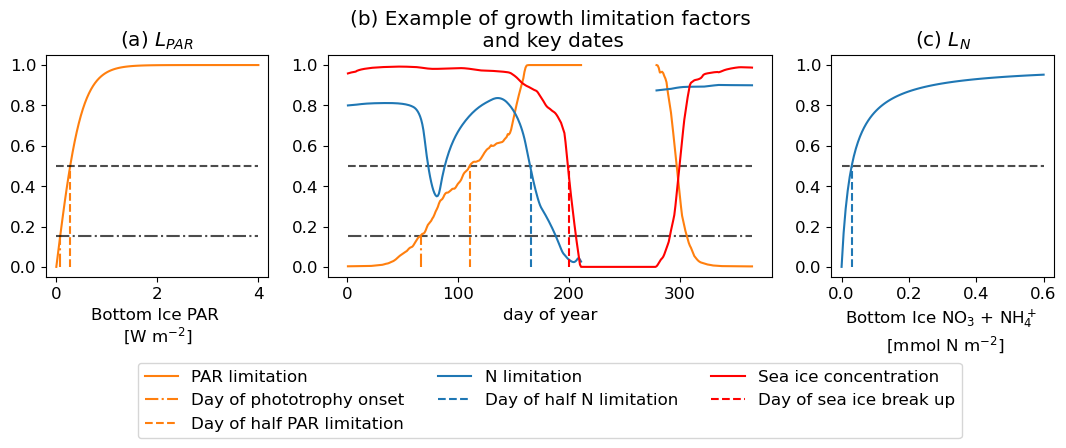

In [18]:
def LimPAR(par): return np.tanh( 2.0 * par)
def LimN(n): return n/0.03 / ( n/0.03 + 1.0) # for values in mmol m2 multply by z bottom ice = 0.03m

per=past
year=1988

limpar=lim[per+'limpar'].sel(time_counter=str(year)).limpar
limN=lim[per+'limN'].sel(time_counter=str(year)).limN
doyPARlim = diagn[per].doyPARlim5.sel(year=year)
doyPARlim15 = diagn[per].doyPARlim15.sel(year=year)
doyNlim = diagn[per].doyNlim5.sel(year=year)
sicy=dadic[runs[per]+'biolog'].ileadfra2.sel(time_counter=str(year))
doySIbu=diagn[per].doySIbreak.sel(year=year)
doySwitch=diagn[per].doyPARlimGTnlim.sel(year=year)
# leastlim=diagn[per].least_lim.sel(year=year)
# ia=dadic[runs[per]+'biolog'].icediagca.sel(time_counter=str(year))



# xi,yi =[ia.max(dim=['time_counter']).argmax(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]
# xi,yi =[doyNlim.argmax(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]
# xi,yi=259, 119 ##CAA nemesis
# xi,yi=379, 2 ## low lat N snd spike
# xi,yi= 150,150 # beafirt low
# xi,yi=158, 92 ## amundsen gulf 2nd N max
# xi,yi=310, 100 ## baffin 2nd N
# xi,yi =[clim[per+'icedia'].sel(dayofyear=slice(250,365)).max(dim=['dayofyear']).argmax(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]
# xi,yi = [doySIbu.where(doySIbu>50).argmax(dim=['x','y'],skipna=True)[k].values for k in ['x','y']]
# xi,yi=412, 194 # greenland crazy ice
# xi,yi=128, 110 ## near amdmusen
# xi,yi=180,345 #siberia
# xi,yi=85,288 #siberia
# xi,yi= 235, 46  #CAA
# xi,yi=148, 87#CAA
# xi,yi=169, 85 ## ~ulu
xi,yi=180, 55 ## in paper

print(xi,yi)



plt.rcParams.update({'font.size': 12})
# fig,ax=plt.subplots(1,3,figsize=(13,3))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 1],top=0.85) 
fig=plt.figure(figsize=(13,3))
ax=[plt.subplot(gs[i]) for i in range(3)]


pc,nc,ic='tab:orange','tab:blue','r'
days=range(1,366)
# ax[1].set_xlim(1,365)
ax[1].plot([1,365],[0.5,0.5],'k--',alpha=0.7)
ax[1].plot([1,365],[0.155,0.155],'k-.',alpha=0.7)

smLpar = limpar.isel(x=xi,y=yi).rolling(time_counter=14,min_periods=1,center=True).mean()
ax[1].plot(days,smLpar,c=pc,label='PAR limitation')
dlimP15 = doyPARlim15.isel(x=xi,y=yi)
ax[1].plot([dlimP15,dlimP15],[0,0.155],'-.',c=pc, label='Day of phototrophy onset')
# ax[1].plot([1,dlimP15],[0.155,0.155],'-.',c=pc)
dlimP = doyPARlim.isel(x=xi,y=yi)
ax[1].plot([dlimP,dlimP],[0,0.5],'--',c=pc, label='Day of half PAR limitation')
# ax[1].plot([1,dlimP],[0.5,0.5],'--',c=pc)

smLn = limN.isel(x=xi,y=yi).rolling(time_counter=14,min_periods=1,center=True).mean()
ax[1].plot(days,smLn,c=nc,label='N limitation')
dlimN = doyNlim.isel(x=xi,y=yi)
ax[1].plot([dlimN,dlimN],[0,0.5],'--',c=nc, label='Day of half N limitation')
# ax[1].plot([dlimN,365],[0.5,0.5],'--',c=nc)

# dlimeq = doySwitch.isel(x=xi,y=yi)
# ax[1].plot([dlimeq,dlimeq],[0,smLn.isel(time_counter=int(dlimeq)-1)],'tab:brown',ls='--', label='Day of limitation switch')
# ax[1].plot([0,dlimeq],[nlim.isel(x=xi,y=yi).sel(dayofyear=dlimeq)]*2,'tab:olive',ls='-', label='Limitation on day of limitation switch')

smSic = sicy.isel(x=xi,y=yi).rolling(time_counter=14,min_periods=1,center=True).mean()
ax[1].plot(days,smSic,ic,label='Sea ice concentration')
dlimSIb = doySIbu.isel(x=xi,y=yi)
ax[1].plot([dlimSIb,dlimSIb],[0,0.5],'--',c=ic, label='Day of sea ice break up')
# ax[1].plot([dlimSIb,365],[0.5,0.5],'--',c=ic)


# least_lim = dgnst.least_lim(clim[rgn+scn+'limpar'].isel(x=xi,y=yi), clim[rgn+scn+'limN'].isel(x=xi,y=yi))
# ax[1].plot([1,365],[least_lim]*2,'-.',c='tab:olive',label='Least limitation')


ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -.35), ncol=3)   
ax[1].set_xlabel('day of year')
ax[1].set_title('(b) Example of growth limitation factors\n and key dates')



p5 =0.27
p15=0.0783
ax[0].set_xlabel('Bottom Ice PAR \n[W m$^{-2}$]')
ax[0].set_title('(a) $L_{PAR}$')
ax[0].plot(np.linspace(0,4,100), LimPAR(np.linspace(0,4,100)), pc) 
ax[0].plot([p5,p5],[0,0.5],'--',c=pc)
ax[0].plot([0,4],[0.5,0.5],'--',c='k',alpha=0.7)
ax[0].plot([p15,p15],[0,0.155],'-.',c=pc)
ax[0].plot([0,4],[0.155,0.155],'-.',c='k',alpha=0.7)

n5 =0.03
ax[2].set_xlabel('Bottom Ice NO$_3$ + NH$_4^+$ \n [mmol N m$^{-2}$]')
ax[2].set_title('(c) $L_{N}$')
ax[2].plot(np.linspace(0,0.6,100), LimN(np.linspace(0,0.6,100)),nc) 
ax[2].plot([n5,n5],[0,0.5],'--',c=nc)
ax[2].plot([0,0.6],[0.5,0.5],'--',c='k',alpha=0.7)

for a in ax:
    a.set_ylim(-0.05,1.05)
    
# plt.savefig('figs/IAphenology23/limiation functions.eps',bbox_inches='tight',dpi=600)
plt.savefig('../figs/IAphenology23/limitation functions.png',bbox_inches='tight',dpi=300)